In [129]:
#from IPython.core.debugger import set_trace
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-12-02 19:54:06,170: Credentials are already in use. The existing account in the session will be replaced.


In [130]:
#Custom library
from __future__ import print_function

import os
import sys
sys.path.append("../Qiskit_Dynamic_Modelling")
sys.path.append("./modelQ")
sys.path.append("./dynamicsQ")

from visualize import *
from ode_solver import *
#from network import *
from dataloader import *
from lagrangian import *

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
#from torchsummary import summary

from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.circuit.random import random_circuit
from qiskit import transpile, assemble

In [142]:
print("--- Loading training and test data... ---")
train_data = np.load('train_dataset.npz')
train_inputs = train_data["input"]
train_labels = train_data["labels"]

#train_dataset = DynamicsDataset(train_inputs, train_labels)
X_train = train_inputs[:1000]
y_train = train_labels[:1000]

#train_dataset = DynamicsDataset(train_inputs, train_labels)
train_dataset = DynamicsDataset(X_train, y_train)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=1,
                                                 shuffle=True,
                                                 collate_fn=DynamicsDataset.collate_fn,
                                                 pin_memory=True,
                                                 num_workers=1)
test_data = np.load('val_dataset.npz')
test_inputs = train_data["input"]
test_labels = train_data["labels"]
test_dataset = DynamicsDataset(test_inputs, test_labels)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=1,
                                                 shuffle=False,
                                                 collate_fn=DynamicsDataset.collate_fn,
                                                 pin_memory=True,
                                                 num_workers=1)
print("--- Loading training and test data completed ---")

--- Loading training and test data... ---
--- Loading training and test data completed ---


In [143]:
for (X_train, y_train) in train_dataloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    print('X_train:', X_train)
    print('y_train:', y_train)
    break

for (X_test, y_test) in test_dataloader:
    print('X_test:', X_test.size(), 'type:', X_test.type())
    print('y_test:', y_test.size(), 'type:', y_test.type())
    print('X_test:', X_test)
    print('y_test:', y_test)
    break

X_train: torch.Size([1, 4]) type: torch.DoubleTensor
y_train: torch.Size([1, 4]) type: torch.DoubleTensor
X_train: tensor([[-1.5729, -0.2772,  0.0290, -0.0807]], dtype=torch.float64)
y_train: tensor([[ 0.0290, -0.0807,  9.8105,  0.0192]], dtype=torch.float64)
X_test: torch.Size([1, 4]) type: torch.DoubleTensor
y_test: torch.Size([1, 4]) type: torch.DoubleTensor
X_test: tensor([[ 1.9537,  0.2797, -0.0780, -0.2268]], dtype=torch.float64)
y_test: tensor([[-0.0780, -0.2268, -9.3138, -3.6618]], dtype=torch.float64)


In [144]:
class QCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, kernel_size, backend, shots, threshold):
        # --- Circuit definition start ---
        self.n_qubits = kernel_size ** 2
        self._circuit = qiskit.QuantumCircuit(self.n_qubits,2)
        
        all_qubits = [i for i in range(self.n_qubits)]        
        self._circuit.h(all_qubits)
        
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):
            self._circuit.rx(self.theta[i], i)
        
        #self._circuit.ccx(0,1,2,3)
        self._circuit.cx(0,2)
        self._circuit.cx(1,3)
        
        self._circuit.barrier()
        '''
        self._circuit.measure(0,0)
        self._circuit.measure(1,1)
        self._circuit.measure(2,2)
        self._circuit.measure(3,3)
        '''
        #self._circuit += random_circuit(self.n_qubits, 2)
        #self._circuit.measure_all()
        '''
        self._circuit.measure(0,2)
        self._circuit.measure(1,1)
        '''
        self._circuit.measure(2,0)
        self._circuit.measure(3,1)
        
        # ---- Circuit definition end ----

        self.backend   = backend
        self.shots     = shots
        self.threshold = threshold

    def run(self, data):
        # data shape: tensor (1, 5, 5)
        # val > self.threshold  : |1> - rx(pi)
        # val <= self.threshold : |0> - rx(0)

        # reshape input data
        # [1, kernel_size, kernel_size] -> [1, self.n_qubits]
       # print('1',data)
        #data = torch.reshape(data, (1, self.n_qubits))
        #print(data)
        
        # encoding data to parameters
        thetas = [data]
        #for dat in data:
           # print(dat)
           # theta = []
           # for val in dat:
             #   if val > self.threshold:
            #        theta.append(np.pi)
            #    else:
             #       theta.append(0)
            #thetas.append(theta)
        
        #print('2',thetas)
        ListTarget = []
        #print(target)
        for valT in data.detach().numpy():
            #print(val)            
            for j in range(len(valT)):
                #print(qcr[0])
                ListTarget.append(valT[j])
        #print('ab',ListTarget)
        param_dict = dict()
        i= 0
        for theta in ListTarget:
            #print(theta)
            #for i in range(self.n_qubits):
            param_dict[self.theta[i]] = theta#[i]
            i += 1
        param_binds = [param_dict]
        #print('3',param_binds)
        #set_trace()
        # execute random quantum circuit
        List = [thetas]
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = param_binds)#[{self.theta: theta} for theta in List])
        #set_trace()
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        #print('4',result)
        return result

{'11': 18, '01': 30, '10': 26, '00': 26}


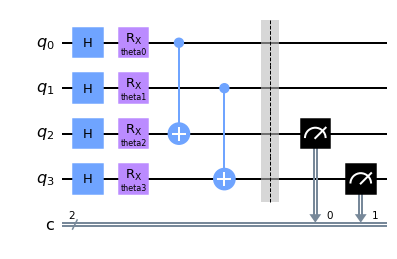

In [145]:
backend = qiskit.Aer.get_backend('qasm_simulator')
filter_size = 2
circ = QCircuit(filter_size, backend, 100, 127)
#data = torch.tensor([[0, 200], [100, 255]])
data = torch.tensor([[-0.2397, -2.9656, -0.1623, -0.0680]])#[5,6,7,7]
#
#print(data)
#print(data.size())
print(circ.run(data))

circ._circuit.draw(output='mpl')

In [146]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        #print('hFor:', input)
        #print('hFor1:', input[0])
        #print('hFor2:', input[0].tolist())
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        #print('6',input)
        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        #print('5',input)
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [147]:
class LagrangianNeuralNetwork(torch.nn.Module):
    def __init__(self, D_in, hidden_list, D_out):
        """
        Neural Network used to approximate a paramaterized system lagrangian
        """
        super(LagrangianNeuralNetwork, self).__init__()
        self.model_layers = torch.nn.ModuleList()

        # input layer
        self.model_layers.append(torch.nn.Linear(D_in, hidden_list[0]))
        # self.model_layers.append(torch.nn.BatchNorm1d(hidden_list[0]))
        self.model_layers.append(torch.nn.Softplus())
        #self.model_layers.append(Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2))
        # add all hiden layers
        for i in range(1, len(hidden_list)):
            self.model_layers.append(torch.nn.Linear(hidden_list[i-1], hidden_list[i]))
            # self.model_layers.append(torch.nn.BatchNorm1d(hidden_list[i]))
            self.model_layers.append(torch.nn.Softplus())
        #self.quanv = Quanv(1, 6, kernel_size=5)
        #self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        #self.model_layers.append(Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2))
        # output layer
        self.model_layers.append(torch.nn.Linear(hidden_list[-1], D_out))
        self.model_layers.append(torch.nn.Softplus())

    def forward(self, x):
        """
        applies all of the model layers, and returns the single output value,
        which in this case is the lagrangian of the system, representing the
        total energy
        """
        for layer in self.model_layers:
            #print(len(self.model_layers))
            #if(count >= (len(self.model_layers) - 3)):
                #print(count)
                #print(x)
            #    x = self.hybrid(x)
                #print(x)
            x = layer(x)
        #x = self.hybrid(x)
        #x = layer(x)
        #x = self.hybrid(x)
        #print("2 ", x)
        #for layer in self.model_layers:
         #   print('7',x)
         #   x = self.hybrid(x)
         #   x = layer(x)
            #x = self.hybrid(x)
        #print('pH', x)                
        
        return x

In [148]:
# determine device
print("--- Checking for CUDA Device... ---")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

--- Checking for CUDA Device... ---


In [ ]:
# organize data
#print(train_inputs.shape[1])
input_size = 4#train_inputs.shape[1]
output_size = 1  # for all lagrangian systems, output should be just a scalar energy value

# build model
print("--- Constructing Model... ---")
D_in = input_size  # state size
# hidden_list = [D_in, 256, 256, 256, 256, 256]
hidden_list = [D_in, 32, 64, 128, 256, 512, 256, 128, 64, 32]
D_out = output_size
lnn_model = LagrangianNeuralNetwork(D_in, hidden_list, D_out)
#summary(lnn_model, (1, 28, 28), device='cpu')
# set up training parameters
learning_rate = 1e-4
weight_decay = 1e-5
momentum = 0.9
num_epochs = 20
optimizer = torch.optim.Adam(lnn_model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

if os.path.isfile("model_weights.pth"):
    print("Re-loading existing weights!")
    checkpoint = torch.load("model_weights.pth")
    lnn_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# ensure model is in train mode so gradients are properly calculated
lnn_model.train()
# load device to either GPU or CPU depending on hardware
lnn_model.to(device)

# set up loss function
loss_fcn = torch.nn.MSELoss()

# set up GradScaler to improve run speed
scaler = torch.cuda.amp.GradScaler()

print("--- Beginning Training! ---")
loss_list = []
lnn_model.train()
for epoch in range(num_epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        #print('8',data)
        optimizer.zero_grad()
        for p in lnn_model.parameters(): p.grad = None
        #print(data)
        backend = qiskit.Aer.get_backend('qasm_simulator')
        filter_size = 2
        circ = QCircuit(filter_size, backend, 100, 127)
        #data = torch.tensor([[0, 200], [100, 255]])
        #print(data)# = data#[1,2,3,4]
        Quantum = circ.run(data)
        #print('q', Quantum)
        qdata = []
        for key, val in Quantum.items():
            qdata.append(val)
        #print(qdata)
        #inData = torch.tensor(qdata)
        dataIn = torch.squeeze(torch.tensor(qdata))
        targetQData = circ.run(target)
        
        targetdata = []
        for keyt, valt in targetQData.items():
            targetdata.append(valt)
        #print(qdata)
        #inData = torch.tensor(qdata)
        targetIndata = torch.tensor(targetdata)
        
        # Forward pass
        #output = model(data)
        # Calculating loss
        #loss = loss_func(output, target)
        # output from model is the energy calculated from the parameterized lagrangian
        #print('1',data)
        #data = torch.squeeze(data)
        with torch.cuda.amp.autocast():
            target_pred = solve_euler_lagrange(lnn_model.forward, dataIn.float())
            #print(target_pred)
            #print(target.float())
            loss = loss_fcn(target_pred.unsqueeze(0), targetIndata.float())
        # Backward pass
        scaler.scale(loss).backward()
        # Optimize the weights
        scaler.step(optimizer)
        #print("Iter Num: ", batch_idx)
        
        #if (batch_idx == 10):
            #print("Iter Num: ", batch_idx)
         #   break
        #print("Iter Num: ", len(train_dataloader))
        #print("Iter Num: ", batch_idx)
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / num_epochs, loss_list[-1]))

print('end')

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid LQNN Training')
plt.xlabel('Training Iterations')
#plt.ylabel('Neg Log Likelihood Loss')
plt.ylabel('Loss')